# Applying Logistic Regression

<p>
After Benchmarking the problem using naive bayes algorithm, tried logistic regression for the problem
as linear models works well for high dimensional data
</p>

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
import matplotlib.patches as mpatches
from math import log
import re
import nltk
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
from scipy import sparse
import os

In [35]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y) 
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    cmap=sn.light_palette("blue")
    plt.subplot(1, 3, 1)
    sn.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sn.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    sn.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [4]:
#Reading data from database
con = sqlite3.connect('final.sqlite') 
data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

In [5]:
row_list = list(np.random.choice(data.shape[0], int(100000), replace=False))
total_data = data.iloc[row_list]
print("Shape of dataset", total_data.shape)

Shape of dataset (100000, 12)


In [36]:
#Saving the 6k dataset in a pickle file
total_data.to_pickle('./logistic_regression_data.pkl')

In [3]:
#Reading the 100K dataset from the pickle file
total_data = pd.read_pickle("./logistic_regression_data.pkl")
labels = total_data['Score']
print("labels shape",labels.shape)

labels shape (100000,)


In [4]:
labels = labels.replace('positive', 1)
labels = labels.replace('negative', 0)

In [5]:
#Splitting the total data into train, test and cross-validation data
#Splitup Proportion : Train data - 60%, Cross-Validation - 20%, Test data - 20%
X_train, X_test, Y_train, Y_test = train_test_split(total_data['CleanedText'].values, labels, test_size=0.4)
print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)
print("Y_train shape", Y_train.shape)
print("Y_test shape", Y_test.shape)
print("="*40)
X_test, X_cv, Y_test, Y_cv = train_test_split(X_test, Y_test, test_size=0.5)
print("X_test shape", X_test.shape)
print("Y_test shape", Y_test.shape)
print("X_cv shape", X_cv.shape)
print("Y_cv shape", Y_cv.shape)
print("-"*40)
print("X_train shape", X_train.shape)
print("Y_train shape", Y_train.shape)

X_train shape (60000,)
X_test shape (40000,)
Y_train shape (60000,)
Y_test shape (40000,)
X_test shape (20000,)
Y_test shape (20000,)
X_cv shape (20000,)
Y_cv shape (20000,)
----------------------------------------
X_train shape (60000,)
Y_train shape (60000,)


## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

In [7]:
#Converting the text data in the 200000 data points to BOW Vectors
count_vect = CountVectorizer(min_df=10)  #in scikit-learn
X_train_bow = count_vect.fit_transform(X_train)
X_cv_bow = count_vect.transform(X_cv)
X_test_bow = count_vect.transform(X_test)
print("After vectorizations")
print(X_train_bow.shape, Y_train.shape)
print(X_cv_bow.shape, Y_cv.shape)
print(X_test_bow.shape, Y_test.shape)
standardscalar = StandardScaler(with_mean=False).fit(X_train_bow)
X_train_bow = standardscalar.transform(X_train_bow)
X_cv_bow = standardscalar.transform(X_cv_bow)
X_test_bow = standardscalar.transform(X_test_bow)
print(type(X_train_bow))
feature_list = count_vect.get_feature_names()

After vectorizations
(60000, 6699) (60000,)
(20000, 6699) (20000,)
(20000, 6699) (20000,)
<class 'scipy.sparse.csr.csr_matrix'>


/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation

In [8]:
C = [10**-5, 10**-4, 10**-3,10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4, 10**5]

In [9]:
# Grid-Search on the hyperparameters
tuned_parameters = [{'C': C }]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l1', class_weight = 'balanced'), tuned_parameters, verbose=4, scoring = 'roc_auc', cv=2)
model.fit(X_train_bow, Y_train)

Fitting 2 folds for each of 11 candidates, totalling 22 fits
[CV] C=1e-05 .........................................................
[CV] ............................... C=1e-05, score=0.5, total=   0.1s
[CV] C=1e-05 .........................................................
[CV] ............................... C=1e-05, score=0.5, total=   0.1s
[CV] C=0.0001 ........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] .............................. C=0.0001, score=0.5, total=   0.1s
[CV] C=0.0001 ........................................................
[CV] .............................. C=0.0001, score=0.5, total=   0.1s
[CV] C=0.001 .........................................................
[CV] ................ C=0.001, score=0.8473871538392463, total=   0.1s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


[CV] ................ C=0.001, score=0.8397609055410817, total=   0.1s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.9286803175661239, total=   0.2s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.9253692137968592, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] .................. C=0.1, score=0.8974455097659684, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ................... C=0.1, score=0.896855918317109, total=   0.6s
[CV] C=1 .............................................................
[CV] ..................... C=1, score=0.842689299969164, total=   2.1s
[CV] C=1 .............................................................
[CV] .................... C=1, score=0.8440943053565205, total=   1.9s
[CV] C=10 ............................................................


/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, score=0.8049967785476505, total= 5.5min
[CV] C=10 ............................................................


/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, score=0.8197960511033061, total= 6.9min
[CV] C=100 ...........................................................


/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, score=0.7954688139718293, total= 6.3min
[CV] C=100 ...........................................................


/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, score=0.8093863687198932, total= 6.2min
[CV] C=1000 ..........................................................


/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=1000, score=0.7911513843990539, total= 5.9min
[CV] C=1000 ..........................................................


/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=1000, score=0.8043815962783477, total= 6.1min
[CV] C=10000 .........................................................


/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=10000, score=0.7938624072401685, total= 6.5min
[CV] C=10000 .........................................................


/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=10000, score=0.8035958419587126, total= 5.4min
[CV] C=100000 ........................................................


/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ............... C=100000, score=0.7932070132115472, total= 6.9min
[CV] C=100000 ........................................................


/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed: 62.1min finished


[CV] ............... C=100000, score=0.8024722520480093, total= 6.2min


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=4)

In [10]:
#The Best Hyper-parameter
print(model.best_estimator_)
print("Score", model.score(X_cv_bow, Y_cv))
print("Best Hyper-parameter", model.best_params_)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
Score 0.9309282697780674
Best Hyper-parameter {'C': 0.01}


In [11]:
#Cross Validation to find the best C value
#Iteratively training the Logistic Regression model for best C value 
x_axis = []
y_axis_train = []
y_axis_cv = []
for c in C:
    clf = LogisticRegression(penalty='l1', C=c, class_weight = 'balanced', max_iter=1000)
    clf.fit(X_train_bow, Y_train)
    y_pred = clf.predict_proba(X_train_bow)[:,1]
    fpr, tpr, _ = roc_curve(Y_train, y_pred)
    roc_auc_train = auc(fpr, tpr)
    y_pred = clf.predict_proba(X_cv_bow)[:,1]
    fpr, tpr, _ = roc_curve(Y_cv, y_pred)
    roc_auc_cv = auc(fpr, tpr)
    x_axis.append(c)
    y_axis_train.append(roc_auc_train)
    y_axis_cv.append(roc_auc_cv)
    print("Executing", c, "Roc Train", roc_auc_train, "Roc CV", roc_auc_cv)

Executing 1e-05 Roc Train 0.5 Roc CV 0.5
Executing 0.0001 Roc Train 0.5 Roc CV 0.5
Executing 0.001 Roc Train 0.8979755407273757 Roc CV 0.8919466343986827
Executing 0.01 Roc Train 0.9643858608620043 Roc CV 0.9318397886063052
Executing 0.1 Roc Train 0.9853718770848048 Roc CV 0.9035295507442085
Executing 1 Roc Train 0.9871700589718247 Roc CV 0.8809591428138669
Executing 10 Roc Train 0.9872276328106334 Roc CV 0.8741653291514173
Executing 100 Roc Train 0.9872299681836756 Roc CV 0.8708820358787799
Executing 1000 Roc Train 0.9872318878686719 Roc CV 0.8683840709133748
Executing 10000 Roc Train 0.9872300935167548 Roc CV 0.866059628646948
Executing 100000 Roc Train 0.9872317207578996 Roc CV 0.8637221483687266


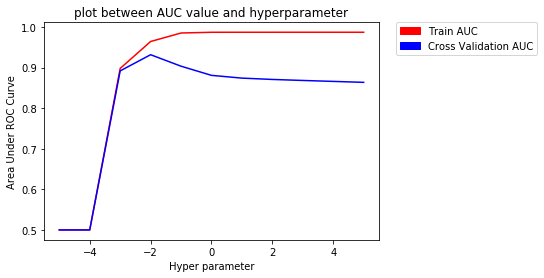

In [12]:
#Plot between AUC and hyperparameter for Validation data and training data
x_axis_log = []
for each in x_axis:
    x_axis_log.append(round(log(each, 10)))
plt.plot(x_axis_log, y_axis_train, color='red')
plt.plot(x_axis_log, y_axis_cv, color='blue')
plt.title('plot between AUC value and hyperparameter')
blue_patch = mpatches.Patch(color='blue', label='Cross Validation AUC')
red_patch = mpatches.Patch(color='red', label='Train AUC')
plt.legend(handles=[red_patch, blue_patch], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Hyper parameter')
plt.ylabel('Area Under ROC Curve')
plt.show()

In [ ]:
Observation:
    In this plot, the Cross validation gives highest AUC at c=0.01 after which the curve falls slightly.
Also distance between train auc and test auc is low here

In [13]:
#Training the Logistic Regression with the best hyperparameter
model = LogisticRegression(penalty='l1', C=0.01, class_weight = 'balanced', max_iter=1000)
model.fit(X_train_bow, Y_train)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

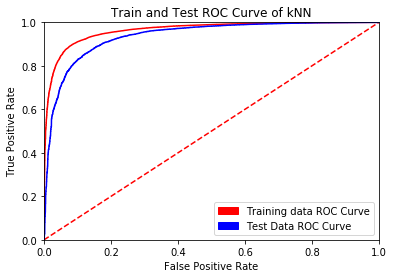

In [14]:
#Plotting the ROC Curve on both train and test data
y_scores = model.predict_proba(X_train_bow)
y_pred_train = model.predict(X_train_bow)
train_fpr, train_tpr, threshold = roc_curve(Y_train, y_scores[:, 1])
train_roc_auc = auc(train_fpr, train_tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(train_fpr, train_tpr, color='red')
blue_patch = mpatches.Patch(color='blue', label='Test Data ROC Curve')
red_patch = mpatches.Patch(color='red', label='Training data ROC Curve')
plt.legend(handles=[red_patch, blue_patch], loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Train and Test ROC Curve of kNN')

y_scores = model.predict_proba(X_test_bow)
y_pred_test = model.predict(X_test_bow)
fpr, tpr, threshold = roc_curve(Y_test, y_scores[:, 1])
test_roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue')
plt.show()

The AUC of the test data is 0.9369499968600048
The AUC of the train data is 0.9643856728623856
The confusion matrix, Recall and precision matrix for train data:
The confusion matrix, Recall and precision matrix for test data:


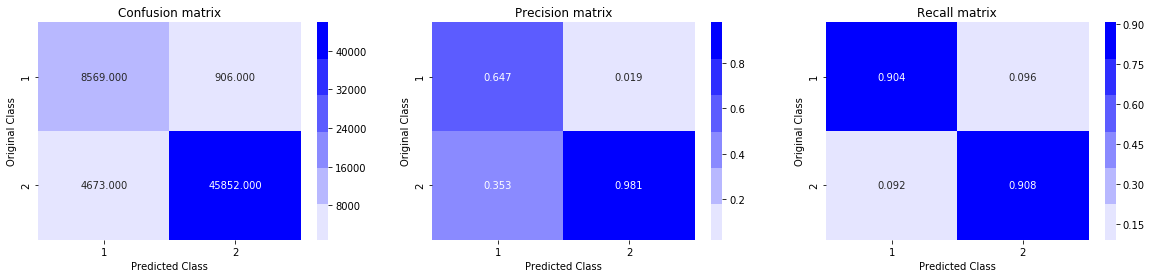

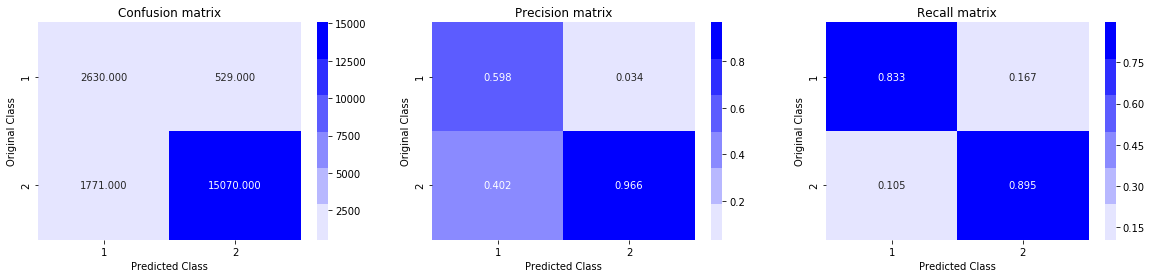

In [15]:
#Test Data AUC Value and Confusion matrix for test data and train data
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
print("The AUC of the test data is", test_roc_auc)
print("The AUC of the train data is", train_roc_auc)
print("The confusion matrix, Recall and precision matrix for train data:")
print("The confusion matrix, Recall and precision matrix for test data:")
plot_confusion_matrix(Y_train, y_pred_train)
plot_confusion_matrix(Y_test, y_pred_test)

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation

In [16]:
w = model.coef_
print("Number of non-zero values on weight vector", np.count_nonzero(w))
print(w.shape)

Number of non-zero values on weight vector 2269
(1, 6764)


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation

In [13]:
# Grid-Search on the hyperparameters
C = [10**-5, 10**-4, 10**-3,10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4, 10**5]
tuned_parameters = [{'C': C }]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l2', class_weight = 'balanced'), tuned_parameters, verbose=4, scoring = 'roc_auc', cv=2)
model.fit(X_train_bow, Y_train)

Fitting 2 folds for each of 11 candidates, totalling 22 fits
[CV] C=1e-05 .........................................................
[CV] ................ C=1e-05, score=0.9252329338494191, total=   0.1s
[CV] C=1e-05 .........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ................ C=1e-05, score=0.9257314023487648, total=   0.1s
[CV] C=0.0001 ........................................................
[CV] ............... C=0.0001, score=0.9250846756053597, total=   0.2s
[CV] C=0.0001 ........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s


[CV] ............... C=0.0001, score=0.9270889855697707, total=   0.2s
[CV] C=0.001 .........................................................
[CV] ................ C=0.001, score=0.9102938655240691, total=   0.3s
[CV] C=0.001 .........................................................
[CV] ................ C=0.001, score=0.9148099143813824, total=   0.3s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.8819529505347994, total=   0.6s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.8878460417719471, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] .................. C=0.1, score=0.8522285309879304, total=   1.2s
[CV] C=0.1 ...........................................................
[CV] .................. C=0.1, score=0.8551875842033432, total=   1.1s
[CV] C=1 .............................................................
[CV] .

/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, score=0.8187171561416138, total=   3.2s
[CV] C=10 ............................................................


/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, score=0.8329706028005723, total=   2.3s
[CV] C=100 ...........................................................


/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, score=0.8130010887345671, total=   4.2s
[CV] C=100 ...........................................................


/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=100, score=0.828780791291159, total=   2.7s
[CV] C=1000 ..........................................................


/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=1000, score=0.8157555939391301, total=   3.4s
[CV] C=1000 ..........................................................


/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=1000, score=0.8270599542993792, total=   2.8s
[CV] C=10000 .........................................................


/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=10000, score=0.8181656594353228, total=   3.3s
[CV] C=10000 .........................................................


/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=10000, score=0.8298145745754262, total=   2.5s
[CV] C=100000 ........................................................


/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ............... C=100000, score=0.8183467045867584, total=   3.2s
[CV] C=100000 ........................................................


/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:   40.0s finished


[CV] ............... C=100000, score=0.8293997565424163, total=   2.5s


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=4)

In [14]:
#The Best Hyper-parameter
print(model.best_estimator_)
print("Score", model.score(X_cv_bow, Y_cv))
print("Best Hyper-parameter", model.best_params_)

LogisticRegression(C=0.0001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
Score 0.9333287418443129
Best Hyper-parameter {'C': 0.0001}


In [19]:
#Cross Validation to find the best C value
#Iteratively training the Logistic Regression model for best C value 
C = [10**-5, 10**-4, 10**-3,10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4, 10**5]
x_axis = []
y_axis_train = []
y_axis_cv = []
for c in C:
    clf = LogisticRegression(penalty='l2', C=c, class_weight = 'balanced', max_iter=1000)
    clf.fit(X_train_bow, Y_train)
    y_pred = clf.predict_proba(X_train_bow)[:,1]
    fpr, tpr, _ = roc_curve(Y_train, y_pred)
    roc_auc_train = auc(fpr, tpr)
    y_pred = clf.predict_proba(X_cv_bow)[:,1]
    fpr, tpr, _ = roc_curve(Y_cv, y_pred)
    roc_auc_cv = auc(fpr, tpr)
    x_axis.append(c)
    y_axis_train.append(roc_auc_train)
    y_axis_cv.append(roc_auc_cv)
    print("Executing", c, "Roc Train", roc_auc_train, "Roc CV", roc_auc_cv)

Executing 1e-05 Roc Train 0.9537962350465234 Roc CV 0.929054568336477
Executing 0.0001 Roc Train 0.9703386933243163 Roc CV 0.9301573231836078
Executing 0.001 Roc Train 0.9814649786737932 Roc CV 0.9182313423670279
Executing 0.01 Roc Train 0.9860503248868413 Roc CV 0.8978544442077476
Executing 0.1 Roc Train 0.9871093225616514 Roc CV 0.8815727674580978
Executing 1 Roc Train 0.9872220137109166 Roc CV 0.8749272480846599
Executing 10 Roc Train 0.9872299744503296 Roc CV 0.8716729451026752
Executing 100 Roc Train 0.9872316455580521 Roc CV 0.8695535396192511
Executing 1000 Roc Train 0.9872320654238673 Roc CV 0.8681671770634002
Executing 10000 Roc Train 0.9872320173795204 Roc CV 0.8687542685441099
Executing 100000 Roc Train 0.9872318460909788 Roc CV 0.869113790052696


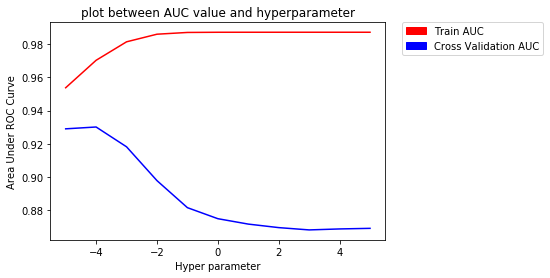

In [20]:
#Plot between AUC and hyperparameter for Validation data and training data
x_axis_log = []
for each in x_axis:
    x_axis_log.append(round(log(each, 10)))
plt.plot(x_axis_log, y_axis_train, color='red')
plt.plot(x_axis_log, y_axis_cv, color='blue')
plt.title('plot between AUC value and hyperparameter')
blue_patch = mpatches.Patch(color='blue', label='Cross Validation AUC')
red_patch = mpatches.Patch(color='red', label='Train AUC')
plt.legend(handles=[red_patch, blue_patch], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Hyper parameter')
plt.ylabel('Area Under ROC Curve')
plt.show()

In [ ]:
Observation:
        Cross validation auc is highest at 10**-4 after which the curve falls steeply.At the same C value, train data
has a high auc too hence choosing C=10**-4

In [21]:
#Training the Logistic Regression Model with the best hyperparameter
model = LogisticRegression(penalty='l2', C=0.0001, class_weight = 'balanced', max_iter=1000)
model.fit(X_train_bow, Y_train)

LogisticRegression(C=0.0001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

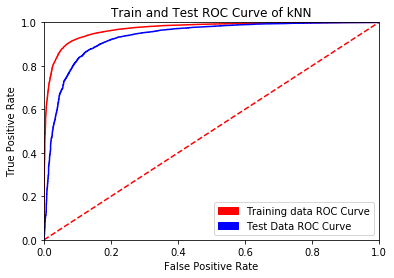

In [22]:
#Plotting the ROC Curve on both train and test data
y_scores = model.predict_proba(X_train_bow)
y_pred_train = model.predict(X_train_bow)
train_fpr, train_tpr, threshold = roc_curve(Y_train, y_scores[:, 1])
train_roc_auc = auc(train_fpr, train_tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(train_fpr, train_tpr, color='red')
blue_patch = mpatches.Patch(color='blue', label='Test Data ROC Curve')
red_patch = mpatches.Patch(color='red', label='Training data ROC Curve')
plt.legend(handles=[red_patch, blue_patch], loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Train and Test ROC Curve of kNN')

y_scores = model.predict_proba(X_test_bow)
y_pred_test = model.predict(X_test_bow)
fpr, tpr, threshold = roc_curve(Y_test, y_scores[:, 1])
test_roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue')
plt.show()

The AUC of the test data is 0.9334967916505038
The AUC of the train data is 0.9703386933243163
The confusion matrix, Recall and precision matrix for train data:
The confusion matrix, Recall and precision matrix for test data:


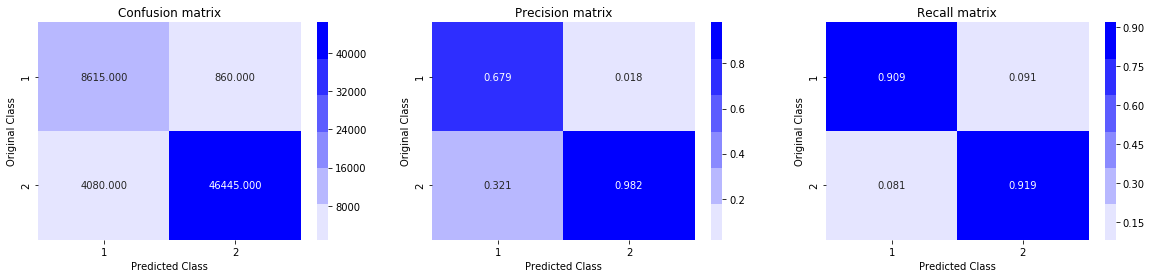

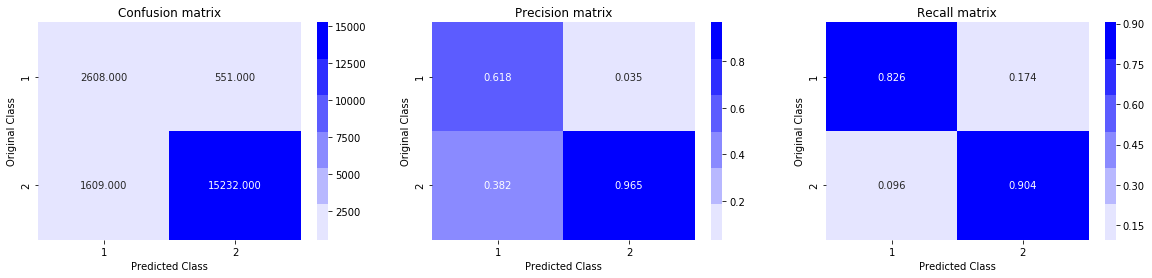

In [23]:
#Test Data AUC Value and Confusion matrix for test data and train data
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
print("The AUC of the test data is", test_roc_auc)
print("The AUC of the train data is", train_roc_auc)
print("The confusion matrix, Recall and precision matrix for train data:")
print("The confusion matrix, Recall and precision matrix for test data:")
plot_confusion_matrix(Y_train, y_pred_train)
plot_confusion_matrix(Y_test, y_pred_test)

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation

In [24]:
#Adding a small error e = 0.001 to the X_train data
e = 0.001
X_train_bow.data = np.add(X_train_bow.data, e, out=X_train_bow.data, casting="unsafe")

In [25]:
#Training the KNN Model with the best hyperparameter and error added train data
model_test = LogisticRegression(penalty='l1', C=0.001, class_weight = 'balanced', max_iter=1000)
model_test.fit(X_train_bow, Y_train)
wdash = model_test.coef_

In [26]:
#Finding change in the weight of the weight of correct model and weight of model trained with error data
w = model.coef_
wdash = wdash + 10**-6
w = w + 10**-6
per_change = wdash - w

In [27]:
#Sorting the error in the change in descending order
feature_index_list = np.argsort(per_change)
per_change = per_change.tolist()[0]
per_change = sorted(per_change, reverse=True)
x_axis = list(range(1, w.shape[1]+1))

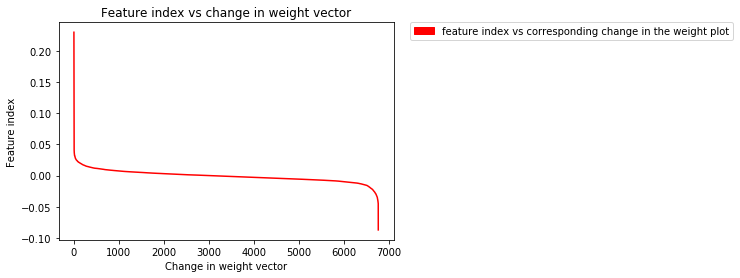

In [28]:
#Plot of the feature index vs corresponding change in the weight plot
plt.plot(x_axis, per_change, color='red')
plt.ylabel('Feature index')
plt.xlabel('Change in weight vector')
plt.title('Feature index vs change in weight vector')
red_patch = mpatches.Patch(color='red', label='feature index vs corresponding change in the weight plot')
plt.legend(handles=[red_patch], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [29]:
# Please write all the code with proper documentation
indices = np.argsort(-model.coef_)[:,:10][0]
indices


array([2588, 3459,  514, 1558, 4304, 2528, 2028, 3927, 2135, 1854])

In [30]:
for each in indices:
    print(feature_list[each])

great
love
best
delici
perfect
good
excel
nice
favorit
easi


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation

In [31]:
indices = np.argsort(model.coef_)[:,:10][0]
indices

array([1672, 5971, 6662, 4903, 3775, 2838,  384,  362, 6517, 6024])

In [32]:
for each in indices:
    print(feature_list[each])

disappoint
terribl
worst
return
money
horribl
bad
aw
wast
thought


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(min_df = 10)
X_train_vec = tf_idf_vect.fit_transform(X_train)
X_cv_vec = tf_idf_vect.transform(X_cv)
X_test_vec = tf_idf_vect.transform(X_test)
print("After vectorizations")
print(X_train_vec.shape, Y_train.shape)
print(X_cv_vec.shape, Y_cv.shape)
print(X_test_vec.shape, Y_test.shape)
print("="*100)
standardscalar = StandardScaler(with_mean=False).fit(X_train_vec)
X_train_vec = standardscalar.transform(X_train_vec)
X_cv_vec = standardscalar.transform(X_cv_vec)
X_test_vec = standardscalar.transform(X_test_vec)
print(type(X_train_vec))

After vectorizations
(60000, 6714) (60000,)
(20000, 6714) (20000,)
(20000, 6714) (20000,)
<class 'scipy.sparse.csr.csr_matrix'>


### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

In [9]:
# Grid-Search on the hyperparameters
C = [10**-5, 10**-4, 10**-3,10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4, 10**5]
tuned_parameters = [{'C': C }]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l1', class_weight = 'balanced'), tuned_parameters,  verbose=4, scoring = 'roc_auc', cv=2)
model.fit(X_train_vec, Y_train)

Fitting 2 folds for each of 11 candidates, totalling 22 fits
[CV] C=1e-05 .........................................................
[CV] ............................... C=1e-05, score=0.5, total=   0.1s
[CV] C=1e-05 .........................................................
[CV] ............................... C=1e-05, score=0.5, total=   0.1s
[CV] C=0.0001 ........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] .............................. C=0.0001, score=0.5, total=   0.1s
[CV] C=0.0001 ........................................................
[CV] .............................. C=0.0001, score=0.5, total=   0.1s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


[CV] ................. C=0.001, score=0.853095025658555, total=   0.1s
[CV] C=0.001 .........................................................
[CV] ................ C=0.001, score=0.8613146590568874, total=   0.1s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.9365392196980014, total=   0.2s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.9363452388644924, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ................... C=0.1, score=0.904276179416922, total=   0.8s
[CV] C=0.1 ...........................................................
[CV] .................. C=0.1, score=0.9077157116896162, total=   0.6s
[CV] C=1 .............................................................
[CV] .................... C=1, score=0.8497905253495367, total=   3.4s
[CV] C=1 .............................................................
[CV] .

/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, score=0.8069551161991855, total= 5.3min
[CV] C=100 ...........................................................


/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, score=0.8222700951790998, total= 4.9min
[CV] C=1000 ..........................................................


/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=1000, score=0.8004075832083245, total= 5.5min
[CV] C=1000 ..........................................................


/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=1000, score=0.7980444762368195, total= 4.8min
[CV] C=10000 .........................................................


/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=10000, score=0.7966191796974199, total= 4.9min
[CV] C=10000 .........................................................


/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=10000, score=0.7939307537198885, total= 5.3min
[CV] C=100000 ........................................................


/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ............... C=100000, score=0.7943006312171708, total= 5.4min
[CV] C=100000 ........................................................


/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed: 41.9min finished


[CV] ............... C=100000, score=0.7897542288447685, total= 4.6min


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=4)

In [10]:
#The Best Hyper-parameter
print(model.best_estimator_)
print("Score", model.score(X_cv_vec, Y_cv))
print("Best Hyper-parameter", model.best_params_)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
Score 0.9401140971331088
Best Hyper-parameter {'C': 0.01}


In [37]:
#Cross Validation to find the best C value
#Iteratively training the Logistic Regression model for best C value 
x_axis = []
y_axis_train = []
y_axis_cv = []
for c in C:
    clf = LogisticRegression(penalty='l1', C=c, class_weight = 'balanced', max_iter=1000)
    clf.fit(X_train_vec, Y_train)
    y_pred = clf.predict_proba(X_train_vec)[:,1]
    fpr, tpr, _ = roc_curve(Y_train, y_pred)
    roc_auc_train = auc(fpr, tpr)
    y_pred = clf.predict_proba(X_cv_vec)[:,1]
    fpr, tpr, _ = roc_curve(Y_cv, y_pred)
    roc_auc_cv = auc(fpr, tpr)
    x_axis.append(c)
    y_axis_train.append(roc_auc_train)
    y_axis_cv.append(roc_auc_cv)
    print("Executing", c, "Roc Train", roc_auc_train, "Roc CV", roc_auc_cv)

Executing 1e-05 Roc Train 0.5 Roc CV 0.5
Executing 0.0001 Roc Train 0.5 Roc CV 0.5
Executing 0.001 Roc Train 0.9084021290956826 Roc CV 0.9021495214811577
Executing 0.01 Roc Train 0.9685085316576998 Roc CV 0.9418592101962926
Executing 0.1 Roc Train 0.9838778639587759 Roc CV 0.9188085958154629
Executing 1 Roc Train 0.9848915432810371 Roc CV 0.8996660897560732
Executing 10 Roc Train 0.9849318859103423 Roc CV 0.8919579009932431
Executing 100 Roc Train 0.9849384721636536 Roc CV 0.8869587520354156
Executing 1000 Roc Train 0.9849411563804329 Roc CV 0.883213756955765
Executing 10000 Roc Train 0.9849418749567536 Roc CV 0.8803306992168584
Executing 100000 Roc Train 0.9849425245998807 Roc CV 0.8777870774007999


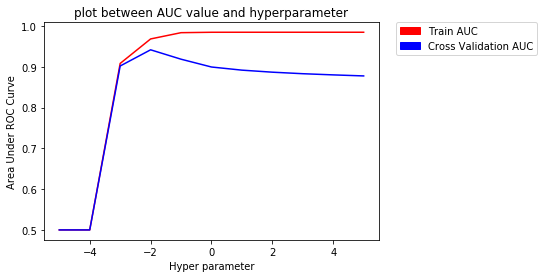

In [38]:
#Plot between AUC and hyperparameter for Validation data and training data
x_axis_log = []
for each in x_axis:
    x_axis_log.append(round(log(each, 10)))
plt.plot(x_axis_log, y_axis_train, color='red')
plt.plot(x_axis_log, y_axis_cv, color='blue')
plt.title('plot between AUC value and hyperparameter')
blue_patch = mpatches.Patch(color='blue', label='Cross Validation AUC')
red_patch = mpatches.Patch(color='red', label='Train AUC')
plt.legend(handles=[red_patch, blue_patch], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Hyper parameter')
plt.ylabel('Area Under ROC Curve')
plt.show()

In [ ]:
Observation:
    In this plot, the Cross validation gives highest auc at c=0.01 after which the curve falls slightly.
Also distance between train auc and test auc is low here

In [39]:
#Training the Logistic Regression Model with the best hyperparameter
model = LogisticRegression(penalty='l1', C=0.01, class_weight = 'balanced', max_iter=1000)
model.fit(X_train_vec, Y_train)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

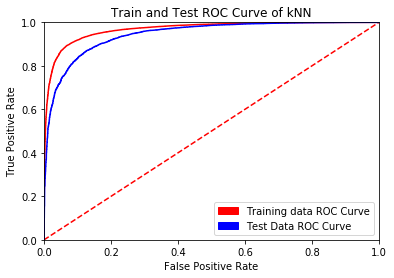

In [40]:
#Plotting the ROC Curve on both train and test data
y_scores = model.predict_proba(X_train_vec)
y_pred_train = model.predict(X_train_vec)
train_fpr, train_tpr, threshold = roc_curve(Y_train, y_scores[:, 1])
train_roc_auc = auc(train_fpr, train_tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(train_fpr, train_tpr, color='red')
blue_patch = mpatches.Patch(color='blue', label='Test Data ROC Curve')
red_patch = mpatches.Patch(color='red', label='Training data ROC Curve')
plt.legend(handles=[red_patch, blue_patch], loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Train and Test ROC Curve of kNN')

y_scores = model.predict_proba(X_test_vec)
y_pred_test = model.predict(X_test_vec)
fpr, tpr, threshold = roc_curve(Y_test, y_scores[:, 1])
test_roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue')
plt.show()

The AUC of the test data is 0.9438699033372087
The AUC of the train data is 0.9685081473029236
The confusion matrix, Recall and precision matrix for train data:
The confusion matrix, Recall and precision matrix for test data:


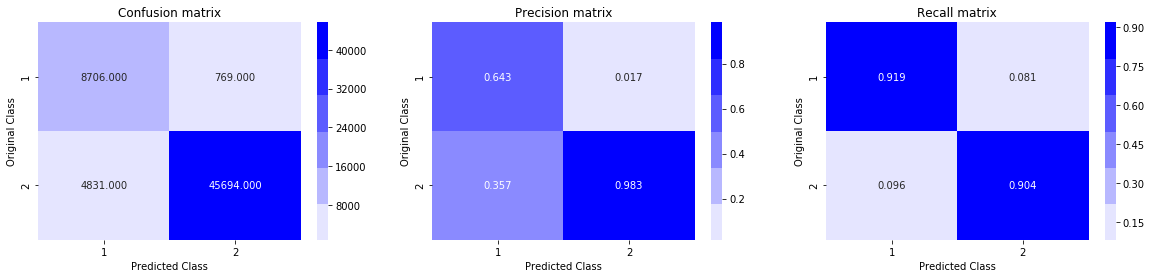

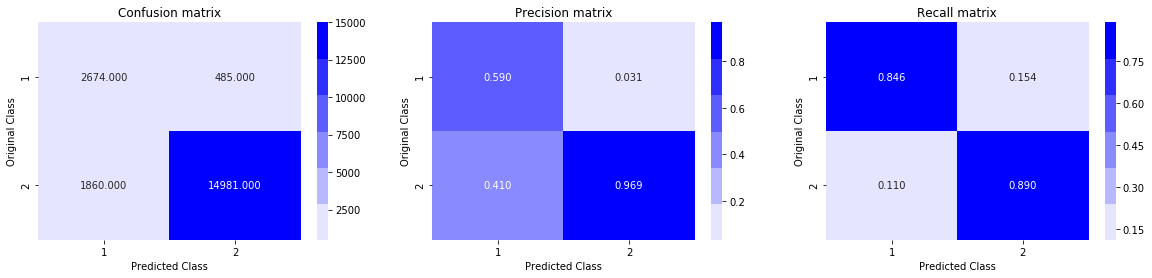

In [41]:
#Test Data AUC Value and Confusion matrix for test data and train data
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
print("The AUC of the test data is", test_roc_auc)
print("The AUC of the train data is", train_roc_auc)
print("The confusion matrix, Recall and precision matrix for train data:")
print("The confusion matrix, Recall and precision matrix for test data:")
plot_confusion_matrix(Y_train, y_pred_train)
plot_confusion_matrix(Y_test, y_pred_test)

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

In [10]:
# Grid-Search on the hyperparameters
C = [10**-5, 10**-4, 10**-3,10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4, 10**5]
tuned_parameters = [{'C': C }]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l2', class_weight = 'balanced'), tuned_parameters,  verbose=3,scoring = 'roc_auc', cv=2)
model.fit(X_train_vec, Y_train)

Fitting 2 folds for each of 11 candidates, totalling 22 fits
[CV] C=1e-05 .........................................................
[CV] ................ C=1e-05, score=0.9291121140434625, total=   0.2s
[CV] C=1e-05 .........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ................ C=1e-05, score=0.9293822451891237, total=   0.1s
[CV] C=0.0001 ........................................................
[CV] ............... C=0.0001, score=0.9307003450851745, total=   0.1s
[CV] C=0.0001 ........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV] ............... C=0.0001, score=0.9301081621410072, total=   0.2s
[CV] C=0.001 .........................................................
[CV] ................ C=0.001, score=0.9160213623759941, total=   0.2s
[CV] C=0.001 .........................................................
[CV] ................ C=0.001, score=0.9145790717017692, total=   0.2s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.8874307523820681, total=   0.4s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.8856152911038155, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] .................. C=0.1, score=0.8549712664451407, total=   0.8s
[CV] C=0.1 ...........................................................
[CV] .................. C=0.1, score=0.8562052430012854, total=   1.0s
[CV] C=1 .............................................................
[CV] .

/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, score=0.8240461506758368, total=   3.7s
[CV] C=10 ............................................................


/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, score=0.8264148699885581, total=   3.7s
[CV] C=100 ...........................................................


/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, score=0.8222156371030129, total=   3.4s
[CV] C=100 ...........................................................


/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, score=0.8350420492060051, total=   2.3s
[CV] C=1000 ..........................................................


/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=1000, score=0.8283475837805814, total=   2.6s
[CV] C=1000 ..........................................................


/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=1000, score=0.8349595461793429, total=   2.4s
[CV] C=10000 .........................................................


/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=10000, score=0.8222543584348937, total=   3.8s
[CV] C=10000 .........................................................


/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=10000, score=0.8350771061371649, total=   2.2s
[CV] C=100000 ........................................................


/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ............... C=100000, score=0.8219053014156552, total=   4.0s
[CV] C=100000 ........................................................


/Users/gayathrisa/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:   39.5s finished


[CV] ............... C=100000, score=0.8351355537441285, total=   2.5s


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=3)

In [11]:
#The Best Hyper-parameter
print(model.best_estimator_)
print("Score", model.score(X_cv_vec, Y_cv))
print("Best Hyper-parameter", model.best_params_)

LogisticRegression(C=0.0001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
Score 0.9356871535222095
Best Hyper-parameter {'C': 0.0001}


In [44]:
#Cross Validation to find the best C value
#Iteratively training the Logistic Regression model for best C value 
x_axis = []
y_axis_train = []
y_axis_cv = []
for c in C:
    clf = LogisticRegression(penalty='l2', C=c, class_weight = 'balanced', max_iter=1000)
    clf.fit(X_train_vec, Y_train)
    y_pred = clf.predict_proba(X_train_vec)[:,1]
    fpr, tpr, _ = roc_curve(Y_train, y_pred)
    roc_auc_train = auc(fpr, tpr)
    y_pred = clf.predict_proba(X_cv_vec)[:,1]
    fpr, tpr, _ = roc_curve(Y_cv, y_pred)
    roc_auc_cv = auc(fpr, tpr)
    x_axis.append(c)
    y_axis_train.append(roc_auc_train)
    y_axis_cv.append(roc_auc_cv)
    print("Executing", c, "Roc Train", roc_auc_train, "Roc CV", roc_auc_cv)

Executing 1e-05 Roc Train 0.9563509117328735 Roc CV 0.9336931291258783
Executing 0.0001 Roc Train 0.9719181282549066 Roc CV 0.9360896471214964
Executing 0.001 Roc Train 0.9812873023229702 Roc CV 0.9277296244351656
Executing 0.01 Roc Train 0.9843323175261338 Roc CV 0.9126080069278032
Executing 0.1 Roc Train 0.9848567153072161 Roc CV 0.8999793067991032
Executing 1 Roc Train 0.9849239126376215 Roc CV 0.8931929692792824
Executing 10 Roc Train 0.9849363352346534 Roc CV 0.8884792375424035
Executing 100 Roc Train 0.9849400576271052 Roc CV 0.8853783621499107
Executing 1000 Roc Train 0.9849413819799755 Roc CV 0.8832596995188755
Executing 10000 Roc Train 0.9849414864242081 Roc CV 0.8827490742154488
Executing 100000 Roc Train 0.984941498957516 Roc CV 0.8826981031130925


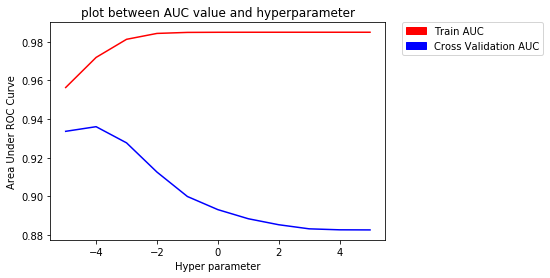

In [45]:
#Plot between AUC and hyperparameter for Validation data and training data
x_axis_log = []
for each in x_axis:
    x_axis_log.append(round(log(each, 10)))
plt.plot(x_axis_log, y_axis_train, color='red')
plt.plot(x_axis_log, y_axis_cv, color='blue')
plt.title('plot between AUC value and hyperparameter')
blue_patch = mpatches.Patch(color='blue', label='Cross Validation AUC')
red_patch = mpatches.Patch(color='red', label='Train AUC')
plt.legend(handles=[red_patch, blue_patch], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Hyper parameter')
plt.ylabel('Area Under ROC Curve')
plt.show()

In [ ]:
Observation:
        Cross validation auc is highest at 10**-4 after which the curve falls steeply.At the same C value, train data
has a high auc too hence choosing C=10**-4

In [46]:
#Training the Logistic Regression Model with the best hyperparameter
model = LogisticRegression(penalty='l2', C=0.0001, class_weight = 'balanced', max_iter=1000)
model.fit(X_train_vec, Y_train)

LogisticRegression(C=0.0001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

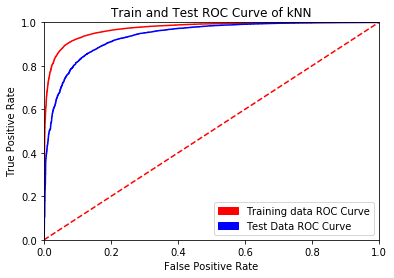

In [47]:
#Plotting the ROC Curve on both train and test data
y_scores = model.predict_proba(X_train_vec)
y_pred_train = model.predict(X_train_vec)
train_fpr, train_tpr, threshold = roc_curve(Y_train, y_scores[:, 1])
train_roc_auc = auc(train_fpr, train_tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(train_fpr, train_tpr, color='red')
blue_patch = mpatches.Patch(color='blue', label='Test Data ROC Curve')
red_patch = mpatches.Patch(color='red', label='Training data ROC Curve')
plt.legend(handles=[red_patch, blue_patch], loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Train and Test ROC Curve of kNN')

y_scores = model.predict_proba(X_test_vec)
y_pred_test = model.predict(X_test_vec)
fpr, tpr, threshold = roc_curve(Y_test, y_scores[:, 1])
test_roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue')
plt.show()

The AUC of the test data is 0.9374359489389608
The AUC of the train data is 0.9719181282549066
The confusion matrix, Recall and precision matrix for train data:
The confusion matrix, Recall and precision matrix for test data:


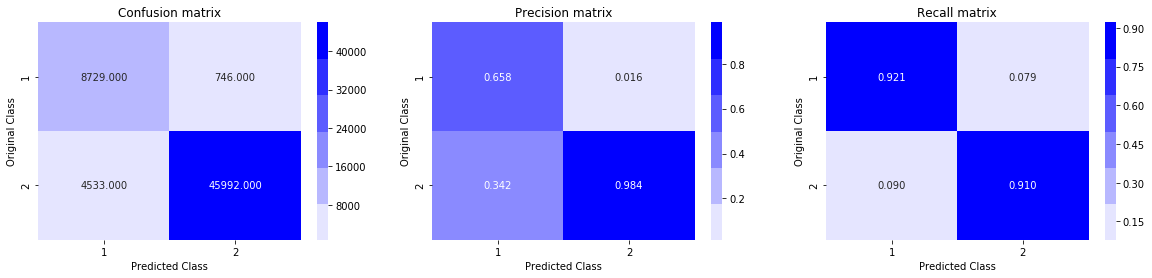

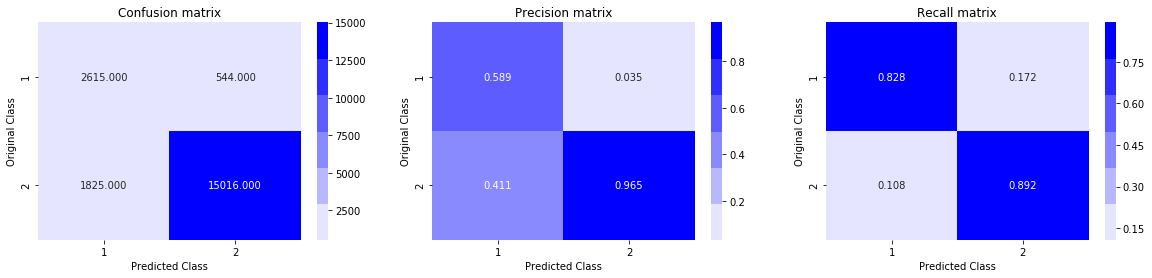

In [48]:
#Test Data AUC Value and Confusion matrix for test data and train data
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
print("The AUC of the test data is", test_roc_auc)
print("The AUC of the train data is", train_roc_auc)
print("The confusion matrix, Recall and precision matrix for train data:")
print("The confusion matrix, Recall and precision matrix for test data:")
plot_confusion_matrix(Y_train, y_pred_train)
plot_confusion_matrix(Y_test, y_pred_test)

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

In [49]:
indices = np.argsort(-model.coef_)[:,:10][0]
indices

array([2588, 3459,  514, 1558, 4304, 2528, 3927, 2028, 2135, 2195])

In [50]:
for each in indices:
    print(feature_list[each])

great
love
best
delici
perfect
good
nice
excel
favorit
find


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

In [51]:
indices = np.argsort(model.coef_)[:,:10][0]
indices

array([1672, 5971, 4903, 6662,  362, 2838,  384, 6517, 3775, 6024])

In [52]:
for each in indices:
    print(feature_list[each])

disappoint
terribl
return
worst
aw
horribl
bad
wast
money
thought


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

In [53]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [54]:
is_your_ram_gt_16g=False
want_to_read_sub_set_of_google_w2v = True
want_to_read_whole_google_w2v = True
if not is_your_ram_gt_16g:
    if want_to_read_sub_set_of_google_w2v and  os.path.isfile('google_w2v_for_amazon.pkl'):
        with open('google_w2v_for_amazon.pkl', 'rb') as f:
            # model is dict object, you can directly access any word vector using model[word]
            model = pickle.load(f)
else:
    if want_to_read_whole_google_w2v and os.path.isfile('GoogleNews-vectors-negative300.bin'):
        model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [55]:
X_train_avgw2v_sent = []
X_cv_avgw2v_sent = []
X_test_avgw2v_sent = []
list_of_sent = []
for sent in X_train:
    X_train_avgw2v_sent.append(sent.split())
for sent in X_cv:
    X_cv_avgw2v_sent.append(sent.split())
for sent in X_test:
    X_test_avgw2v_sent.append(sent.split())
for sent in total_data['CleanedText'].values:
    list_of_sent.append(sent.split())

In [56]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

In [58]:
def avg_w2v_vectorizer(sentences):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(sentences): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return sent_vectors
X_train_vec = avg_w2v_vectorizer(X_train_avgw2v_sent)
X_cv_vec = avg_w2v_vectorizer(X_cv_avgw2v_sent)
X_test_vec = avg_w2v_vectorizer(X_cv_avgw2v_sent)
standardscalar = StandardScaler(with_mean=False).fit(X_train_vec)
X_train_vec = standardscalar.transform(X_train_vec)
X_cv_vec = standardscalar.transform(X_cv_vec)
X_test_vec = standardscalar.transform(X_test_vec)
print(len(X_train_vec))
print(len(X_train_vec[0]))
print(len(X_cv_vec))
print(len(X_cv_vec[0]))
print(len(X_test_vec))
print(len(X_test_vec[0]))

100%|██████████| 20000/20000 [00:23<00:00, 842.85it/s]


60000
50
20000
50
20000
50


### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [0]:
# Please write all the code with proper documentation

In [59]:
# Grid-Search on the hyperparameters
C = [10**-5, 10**-4, 10**-3,10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4, 10**5]
tuned_parameters = [{'C': C }]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l1', class_weight = 'balanced', max_iter=1000), tuned_parameters, verbose=3, scoring = 'roc_auc', cv=2)
model.fit(X_train_vec, Y_train)

Fitting 2 folds for each of 11 candidates, totalling 22 fits
[CV] C=1e-05 .........................................................
[CV] ............................... C=1e-05, score=0.5, total=   0.1s
[CV] C=1e-05 .........................................................
[CV] ............................... C=1e-05, score=0.5, total=   0.1s
[CV] C=0.0001 ........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] .............................. C=0.0001, score=0.5, total=   0.1s
[CV] C=0.0001 ........................................................
[CV] .............................. C=0.0001, score=0.5, total=   0.1s
[CV] C=0.001 .........................................................
[CV] ................ C=0.001, score=0.8867120008109872, total=   0.1s
[CV] C=0.001 .........................................................
[CV] ................ C=0.001, score=0.8878044394095457, total=   0.2s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.9082317590079422, total=   0.3s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.9087019711698787, total=   0.4s
[CV] C=0.1 ...........................................................
[CV] .................. C=0.1, score=0.9092711914225038, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:   59.3s finished


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=3)

In [60]:
#The Best Hyper-parameter
print(model.best_estimator_)
print("Score", model.score(X_cv_vec, Y_cv))
print("Best Hyper-parameter", model.best_params_)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
Score 0.9078049138580752
Best Hyper-parameter {'C': 0.1}


In [61]:
#Cross Validation to find the best C value
#Iteratively training the Logistic Regression model for best C value 
x_axis = []
y_axis_train = []
y_axis_cv = []
for c in C:
    clf = LogisticRegression(penalty='l1', C=c, class_weight = 'balanced', max_iter=1000)
    clf.fit(X_train_vec, Y_train)
    y_pred = clf.predict_proba(X_train_vec)[:,1]
    fpr, tpr, _ = roc_curve(Y_train, y_pred)
    roc_auc_train = auc(fpr, tpr)
    y_pred = clf.predict_proba(X_cv_vec)[:,1]
    fpr, tpr, _ = roc_curve(Y_cv, y_pred)
    roc_auc_cv = auc(fpr, tpr)
    x_axis.append(c)
    y_axis_train.append(roc_auc_train)
    y_axis_cv.append(roc_auc_cv)
    print("Executing", c, "Roc Train", roc_auc_train, "Roc CV", roc_auc_cv)

Executing 1e-05 Roc Train 0.5 Roc CV 0.5
Executing 0.0001 Roc Train 0.5 Roc CV 0.5
Executing 0.001 Roc Train 0.8988141527157458 Roc CV 0.8945059513523875
Executing 0.01 Roc Train 0.9100901818504645 Roc CV 0.9070270521697233
Executing 0.1 Roc Train 0.9104362139487885 Roc CV 0.9078049900480637
Executing 1 Roc Train 0.9104431281569901 Roc CV 0.9078615039720889
Executing 10 Roc Train 0.9104433976231103 Roc CV 0.9078807038492097
Executing 100 Roc Train 0.9104431427791827 Roc CV 0.907882075269004
Executing 1000 Roc Train 0.9104431239792208 Roc CV 0.9078831800238384
Executing 10000 Roc Train 0.9104431386014135 Roc CV 0.907882608598924
Executing 100000 Roc Train 0.9104431490458367 Roc CV 0.9078835800212783


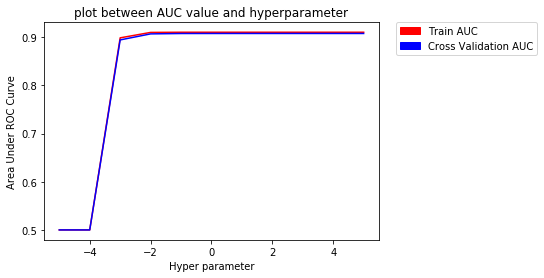

In [62]:
#Plot between AUC and hyperparameter for Validation data and training data
x_axis_log = []
for each in x_axis:
    x_axis_log.append(round(log(each, 10)))
plt.plot(x_axis_log, y_axis_train, color='red')
plt.plot(x_axis_log, y_axis_cv, color='blue')
plt.title('plot between AUC value and hyperparameter')
blue_patch = mpatches.Patch(color='blue', label='Cross Validation AUC')
red_patch = mpatches.Patch(color='red', label='Train AUC')
plt.legend(handles=[red_patch, blue_patch], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Hyper parameter')
plt.ylabel('Area Under ROC Curve')
plt.show()

In [ ]:
Observation:
    In both train and cross-validation, AUC reaches highest value at 10**-1 after which the curve nearly saturates.
Hence any C value > 10**-1 will be optimal.

In [64]:
#Training the Logistic Regression Model with the best hyperparameter
model = LogisticRegression(penalty='l1', C=1, class_weight = 'balanced', max_iter=1000)
model.fit(X_train_vec, Y_train)

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

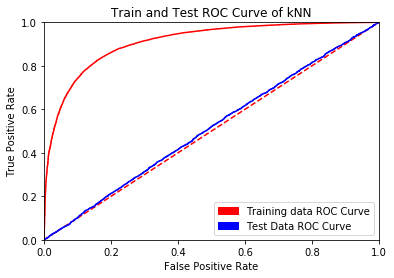

In [65]:
#Plotting the ROC Curve on both train and test data
y_scores = model.predict_proba(X_train_vec)
y_pred_train = model.predict(X_train_vec)
train_fpr, train_tpr, threshold = roc_curve(Y_train, y_scores[:, 1])
train_roc_auc = auc(train_fpr, train_tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(train_fpr, train_tpr, color='red')
blue_patch = mpatches.Patch(color='blue', label='Test Data ROC Curve')
red_patch = mpatches.Patch(color='red', label='Training data ROC Curve')
plt.legend(handles=[red_patch, blue_patch], loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Train and Test ROC Curve of kNN')

y_scores = model.predict_proba(X_test_vec)
y_pred_test = model.predict(X_test_vec)
fpr, tpr, threshold = roc_curve(Y_test, y_scores[:, 1])
test_roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue')
plt.show()

The AUC of the test data is 0.5121206538580805
The AUC of the train data is 0.9104430654904506
The confusion matrix, Recall and precision matrix for train data:
The confusion matrix, Recall and precision matrix for test data:


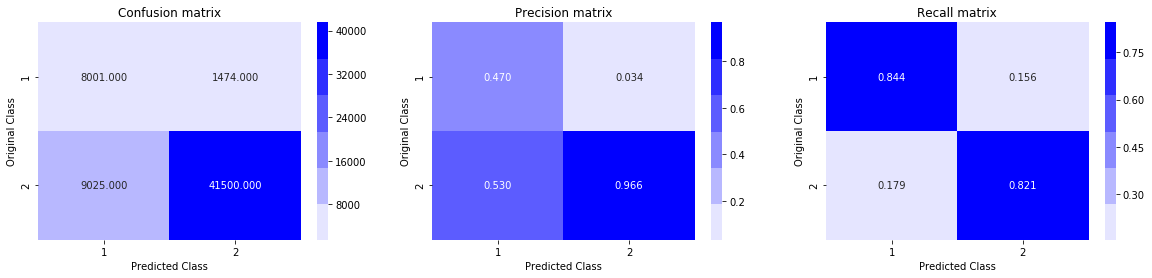

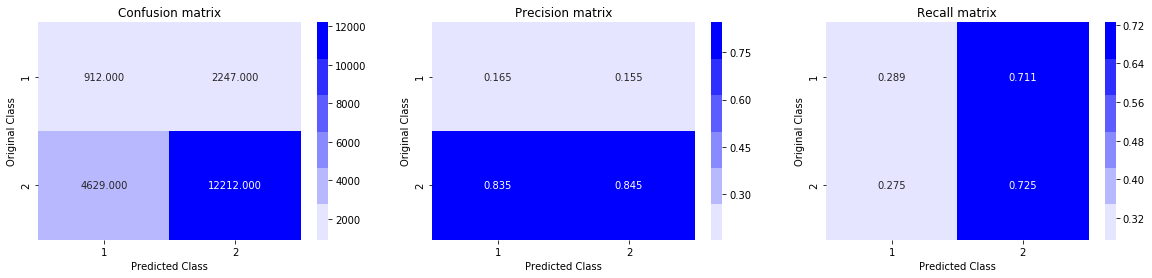

In [66]:
#Test Data AUC Value and Confusion matrix for test data and train data
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
print("The AUC of the test data is", test_roc_auc)
print("The AUC of the train data is", train_roc_auc)
print("The confusion matrix, Recall and precision matrix for train data:")
print("The confusion matrix, Recall and precision matrix for test data:")
plot_confusion_matrix(Y_train, y_pred_train)
plot_confusion_matrix(Y_test, y_pred_test)

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [0]:
# Please write all the code with proper documentation

In [67]:
# Grid-Search on the hyperparameters
C = [10**-5, 10**-4, 10**-3,10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4, 10**5]
tuned_parameters = [{'C': C }]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l2', class_weight = 'balanced', max_iter=1000), tuned_parameters, verbose=3, scoring = 'roc_auc', cv=2)
model.fit(X_train_vec, Y_train)

Fitting 2 folds for each of 11 candidates, totalling 22 fits
[CV] C=1e-05 .........................................................
[CV] ................ C=1e-05, score=0.8784212958528121, total=   0.2s
[CV] C=1e-05 .........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ................ C=1e-05, score=0.8797151889991495, total=   0.1s
[CV] C=0.0001 ........................................................
[CV] ............... C=0.0001, score=0.8974570715732796, total=   0.2s
[CV] C=0.0001 ........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV] ............... C=0.0001, score=0.8972076793949672, total=   0.2s
[CV] C=0.001 .........................................................
[CV] ................ C=0.001, score=0.9075617454985624, total=   0.3s
[CV] C=0.001 .........................................................
[CV] ................ C=0.001, score=0.9073922267405168, total=   0.3s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.9093260219502235, total=   0.4s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.9094019271657683, total=   0.4s
[CV] C=0.1 ...........................................................
[CV] .................. C=0.1, score=0.9093004572062311, total=   0.4s
[CV] C=0.1 ...........................................................
[CV] .................. C=0.1, score=0.9094448967307315, total=   0.4s
[CV] C=1 .............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    8.1s finished


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=3)

In [68]:
#The Best Hyper-parameter
print(model.best_estimator_)
print("Score", model.score(X_cv_vec, Y_cv))
print("Best Hyper-parameter", model.best_params_)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
Score 0.907852113555997
Best Hyper-parameter {'C': 0.1}


In [69]:
#Cross Validation to find the best C value
#Iteratively training the Logistic Regression model for best C value 
x_axis = []
y_axis_train = []
y_axis_cv = []
for c in C:
    clf = LogisticRegression(penalty='l2', C=c, class_weight = 'balanced', max_iter=1000)
    clf.fit(X_train_vec, Y_train)
    y_pred = clf.predict_proba(X_train_vec)[:,1]
    fpr, tpr, _ = roc_curve(Y_train, y_pred)
    roc_auc_train = auc(fpr, tpr)
    y_pred = clf.predict_proba(X_cv_vec)[:,1]
    fpr, tpr, _ = roc_curve(Y_cv, y_pred)
    roc_auc_cv = auc(fpr, tpr)
    x_axis.append(c)
    y_axis_train.append(roc_auc_train)
    y_axis_cv.append(roc_auc_cv)
    print("Executing", c, "Roc Train", roc_auc_train, "Roc CV", roc_auc_cv)

Executing 1e-05 Roc Train 0.8855725938333514 Roc CV 0.8789372890870641
Executing 0.0001 Roc Train 0.9020174239091127 Roc CV 0.8971882199001546
Executing 0.001 Roc Train 0.9094400875242671 Roc CV 0.9062057240928896
Executing 0.01 Roc Train 0.9104115859987284 Roc CV 0.9077258286499348
Executing 0.1 Roc Train 0.9104417662041964 Roc CV 0.907852113555997
Executing 1 Roc Train 0.9104432743789158 Roc CV 0.9078854276285013
Executing 10 Roc Train 0.9104432242456842 Roc CV 0.9078896180778729
Executing 100 Roc Train 0.9104429401573713 Roc CV 0.907890818070193
Executing 1000 Roc Train 0.9104428691352932 Roc CV 0.9078908561651873
Executing 10000 Roc Train 0.9104429840239491 Roc CV 0.9078913323526159
Executing 100000 Roc Train 0.9104428837574857 Roc CV 0.9078908942601815


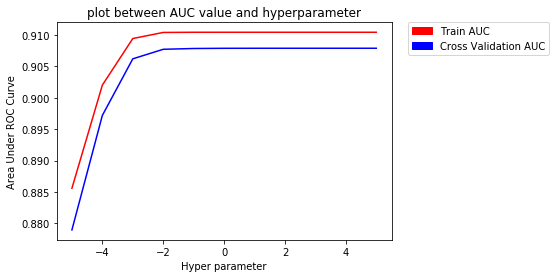

In [70]:
#Plot between AUC and hyperparameter for Validation data and training data
x_axis_log = []
for each in x_axis:
    x_axis_log.append(round(log(each, 10)))
plt.plot(x_axis_log, y_axis_train, color='red')
plt.plot(x_axis_log, y_axis_cv, color='blue')
plt.title('plot between AUC value and hyperparameter')
blue_patch = mpatches.Patch(color='blue', label='Cross Validation AUC')
red_patch = mpatches.Patch(color='red', label='Train AUC')
plt.legend(handles=[red_patch, blue_patch], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Hyper parameter')
plt.ylabel('Area Under ROC Curve')
plt.show()

In [ ]:
Observation:
    AUC is highest at 10**-2 for both train data and cross validation after which the curv saturates.Hence choosing
C=0.01 as optimal hyperparameter

In [71]:
#Training the Logistic Regression Model with the best hyperparameter
model = LogisticRegression(penalty='l2', C=0.01, class_weight = 'balanced', max_iter=1000)
model.fit(X_train_vec, Y_train)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

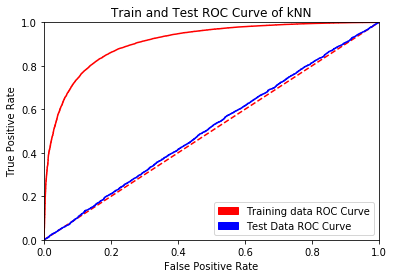

In [72]:
#Plotting the ROC Curve on both train and test data
y_scores = model.predict_proba(X_train_vec)
y_pred_train = model.predict(X_train_vec)
train_fpr, train_tpr, threshold = roc_curve(Y_train, y_scores[:, 1])
train_roc_auc = auc(train_fpr, train_tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(train_fpr, train_tpr, color='red')
blue_patch = mpatches.Patch(color='blue', label='Test Data ROC Curve')
red_patch = mpatches.Patch(color='red', label='Training data ROC Curve')
plt.legend(handles=[red_patch, blue_patch], loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Train and Test ROC Curve of kNN')

y_scores = model.predict_proba(X_test_vec)
y_pred_test = model.predict(X_test_vec)
fpr, tpr, threshold = roc_curve(Y_test, y_scores[:, 1])
test_roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue')
plt.show()

The AUC of the test data is 0.5120218018106109
The AUC of the train data is 0.9104115859987284
The confusion matrix, Recall and precision matrix for train data:
The confusion matrix, Recall and precision matrix for test data:


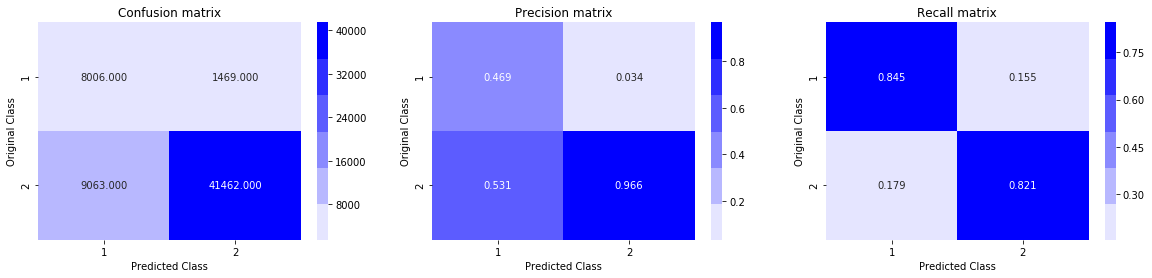

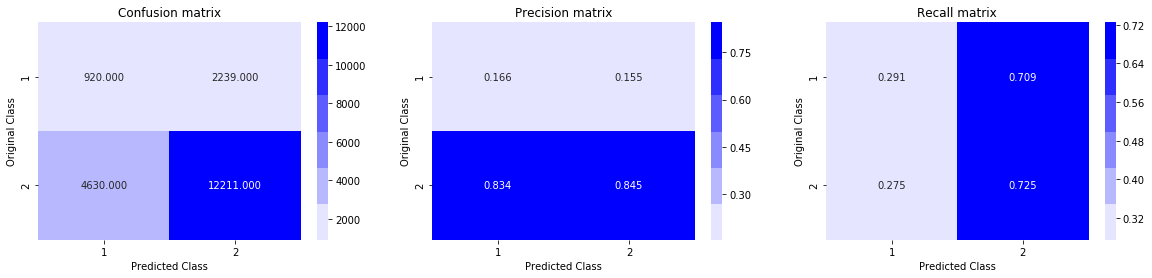

In [73]:
#Test Data AUC Value and Confusion matrix for test data and train data
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
print("The AUC of the test data is", test_roc_auc)
print("The AUC of the train data is", train_roc_auc)
print("The confusion matrix, Recall and precision matrix for train data:")
print("The confusion matrix, Recall and precision matrix for test data:")
plot_confusion_matrix(Y_train, y_pred_train)
plot_confusion_matrix(Y_test, y_pred_test)

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

In [ ]:
X_train_avgw2v_sent = []
X_cv_avgw2v_sent = []
X_test_avgw2v_sent = []
list_of_sent = []
for sent in X_train:
    X_train_avgw2v_sent.append(sent.split())
for sent in X_cv:
    X_cv_avgw2v_sent.append(sent.split())
for sent in X_test:
    X_test_avgw2v_sent.append(sent.split())
for sent in total_data['CleanedText'].values:
    list_of_sent.append(sent.split())

In [12]:
from gensim.models import Word2Vec
X_train_tfidfw2v_sent = []
X_cv_tfidfw2v_sent = []
X_test_tfidfw2v_sent = []
for sent in X_train:
    X_train_tfidfw2v_sent.append(sent.split())
for sent in X_cv:
    X_cv_tfidfw2v_sent.append(sent.split())
for sent in X_test:
    X_test_tfidfw2v_sent.append(sent.split())

In [14]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

In [15]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
from sklearn.feature_extraction.text import TfidfVectorizer
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [16]:
def tfidf_weighted_vector(list_of_sent):
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sent): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors
X_train_vec = tfidf_weighted_vector(X_train_tfidfw2v_sent)
X_cv_vec = tfidf_weighted_vector(X_cv_tfidfw2v_sent)
X_test_vec = tfidf_weighted_vector(X_test_tfidfw2v_sent)
standardscalar = StandardScaler(with_mean=False).fit(X_train_vec)
X_train_vec = standardscalar.transform(X_train_vec)
X_cv_vec = standardscalar.transform(X_cv_vec)
X_test_vec = standardscalar.transform(X_test_vec)
print(len(X_train_vec))
print(len(X_train_vec[0]))
print(len(X_cv_vec))
print(len(X_cv_vec[0]))
print(len(X_test_vec))
print(len(X_test_vec[0]))

100%|██████████| 20000/20000 [00:25<00:00, 798.83it/s]


60000
50
20000
50
20000
50


### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
# Please write all the code with proper documentation

In [78]:
# Grid-Search on the hyperparameters
C = [10**-5, 10**-4, 10**-3,10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4, 10**5]
tuned_parameters = [{'C': C }]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l1', class_weight = 'balanced', max_iter=1000), tuned_parameters,  verbose=3,scoring = 'roc_auc', cv=2)
model.fit(X_train_vec, Y_train)

Fitting 2 folds for each of 11 candidates, totalling 22 fits
[CV] C=1e-05 .........................................................
[CV] ............................... C=1e-05, score=0.5, total=   0.1s
[CV] C=1e-05 .........................................................
[CV] ............................... C=1e-05, score=0.5, total=   0.1s
[CV] C=0.0001 ........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] .............................. C=0.0001, score=0.5, total=   0.1s
[CV] C=0.0001 ........................................................
[CV] .............................. C=0.0001, score=0.5, total=   0.0s
[CV] C=0.001 .........................................................
[CV] ................ C=0.001, score=0.8485100608211994, total=   0.1s
[CV] C=0.001 .........................................................
[CV] ................ C=0.001, score=0.8537377722047148, total=   0.2s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.8823569798359502, total=   0.3s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.8834928171049019, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] .................. C=0.1, score=0.8838686081101359, total=   0.4s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:   56.3s finished


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=3)

In [79]:
#The Best Hyper-parameter
print(model.best_estimator_)
print("Score", model.score(X_cv_vec, Y_cv))
print("Best Hyper-parameter", model.best_params_)

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
Score 0.881475406176448
Best Hyper-parameter {'C': 1}


In [80]:
#Cross Validation to find the best C value
#Iteratively training the Logistic Regression model for best C value 
x_axis = []
y_axis_train = []
y_axis_cv = []
for c in C:
    clf = LogisticRegression(penalty='l1', C=c, class_weight = 'balanced', max_iter=1000)
    clf.fit(X_train_vec, Y_train)
    y_pred = clf.predict_proba(X_train_vec)[:,1]
    fpr, tpr, _ = roc_curve(Y_train, y_pred)
    roc_auc_train = auc(fpr, tpr)
    y_pred = clf.predict_proba(X_cv_vec)[:,1]
    fpr, tpr, _ = roc_curve(Y_cv, y_pred)
    roc_auc_cv = auc(fpr, tpr)
    x_axis.append(c)
    y_axis_train.append(roc_auc_train)
    y_axis_cv.append(roc_auc_cv)
    print("Executing", c, "Roc Train", roc_auc_train, "Roc CV", roc_auc_cv)

Executing 1e-05 Roc Train 0.5 Roc CV 0.5
Executing 0.0001 Roc Train 0.5 Roc CV 0.5
Executing 0.001 Roc Train 0.8711264942379423 Roc CV 0.866125332988345
Executing 0.01 Roc Train 0.8849459702151159 Roc CV 0.8803798893782318
Executing 0.1 Roc Train 0.8853734333038714 Roc CV 0.8812910264040977
Executing 1 Roc Train 0.8853807318668493 Roc CV 0.8814755014139338
Executing 10 Roc Train 0.8853788581373154 Roc CV 0.8814905679841745
Executing 100 Roc Train 0.8853788769372772 Roc CV 0.8814909679816145
Executing 1000 Roc Train 0.8853787892041218 Roc CV 0.8814909489341172
Executing 10000 Roc Train 0.8853788435151229 Roc CV 0.881491044171603
Executing 100000 Roc Train 0.8853789312482784 Roc CV 0.881491158456586


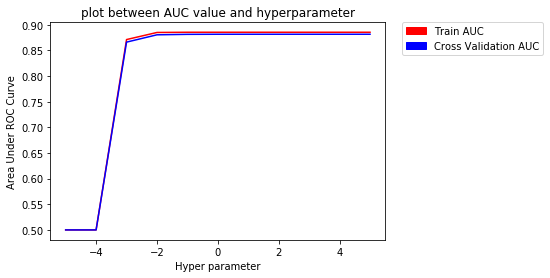

In [81]:
#Plot between AUC and hyperparameter for Validation data and training data
x_axis_log = []
for each in x_axis:
    x_axis_log.append(round(log(each, 10)))
plt.plot(x_axis_log, y_axis_train, color='red')
plt.plot(x_axis_log, y_axis_cv, color='blue')
plt.title('plot between AUC value and hyperparameter')
blue_patch = mpatches.Patch(color='blue', label='Cross Validation AUC')
red_patch = mpatches.Patch(color='red', label='Train AUC')
plt.legend(handles=[red_patch, blue_patch], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Hyper parameter')
plt.ylabel('Area Under ROC Curve')
plt.show()

In [ ]:
Observation:
    In both train and cross-validation, AUC reaches highest value at 10**-2 after which the curve nearly saturates.
Hence any C value > 10**-2 will be optimal.

In [82]:
#Training the Logistic Regression Model with the best hyperparameter
model = LogisticRegression(penalty='l1', C=0.01, class_weight = 'balanced', max_iter=1000)
model.fit(X_train_vec, Y_train)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

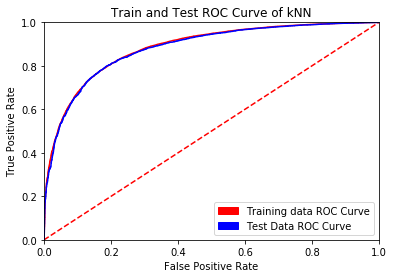

In [83]:
#Plotting the ROC Curve on both train and test data
y_scores = model.predict_proba(X_train_vec)
y_pred_train = model.predict(X_train_vec)
train_fpr, train_tpr, threshold = roc_curve(Y_train, y_scores[:, 1])
train_roc_auc = auc(train_fpr, train_tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(train_fpr, train_tpr, color='red')
blue_patch = mpatches.Patch(color='blue', label='Test Data ROC Curve')
red_patch = mpatches.Patch(color='red', label='Training data ROC Curve')
plt.legend(handles=[red_patch, blue_patch], loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Train and Test ROC Curve of kNN')

y_scores = model.predict_proba(X_test_vec)
y_pred_test = model.predict(X_test_vec)
fpr, tpr, threshold = roc_curve(Y_test, y_scores[:, 1])
test_roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue')
plt.show()

The AUC of the test data is 0.8819006092756003
The AUC of the train data is 0.884946011992809
The confusion matrix, Recall and precision matrix for train data:
The confusion matrix, Recall and precision matrix for test data:


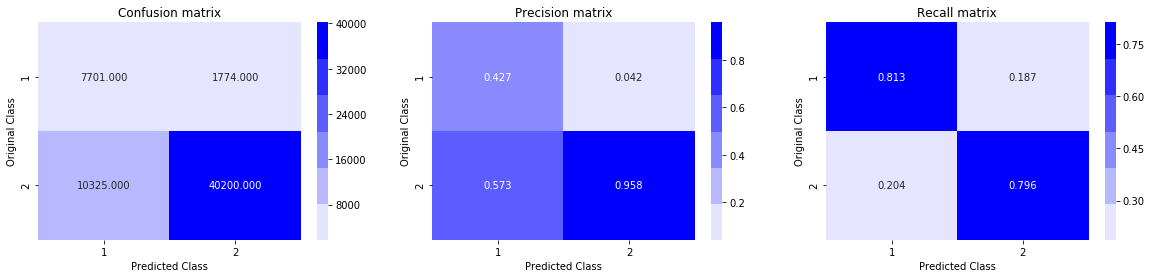

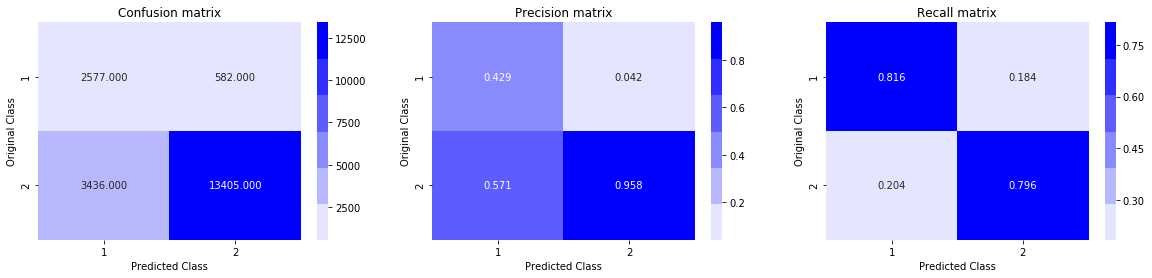

In [84]:
#Test Data AUC Value and Confusion matrix for test data and train data
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
print("The AUC of the test data is", test_roc_auc)
print("The AUC of the train data is", train_roc_auc)
print("The confusion matrix, Recall and precision matrix for train data:")
print("The confusion matrix, Recall and precision matrix for test data:")
plot_confusion_matrix(Y_train, y_pred_train)
plot_confusion_matrix(Y_test, y_pred_test)

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
# Please write all the code with proper documentation

In [85]:
# Grid-Search on the hyperparameters
C = [10**-5, 10**-4, 10**-3,10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4, 10**5]
tuned_parameters = [{'C': C }]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l2', class_weight = 'balanced', max_iter=1000),tuned_parameters,  verbose=3, scoring = 'roc_auc', cv=2)
model.fit(X_train_vec, Y_train)

Fitting 2 folds for each of 11 candidates, totalling 22 fits
[CV] C=1e-05 .........................................................
[CV] ................ C=1e-05, score=0.8394833251618052, total=   0.1s
[CV] C=1e-05 .........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ................ C=1e-05, score=0.8433665303724209, total=   0.1s
[CV] C=0.0001 ........................................................
[CV] ............... C=0.0001, score=0.8657638402135327, total=   0.2s
[CV] C=0.0001 ........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV] ............... C=0.0001, score=0.8665199726498969, total=   0.2s
[CV] C=0.001 .........................................................
[CV] ................. C=0.001, score=0.881175512711384, total=   0.3s
[CV] C=0.001 .........................................................
[CV] ................ C=0.001, score=0.8816962263345873, total=   0.3s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.8838650741602312, total=   0.5s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.8842294250867753, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] .................. C=0.1, score=0.8839617857538442, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] .................. C=0.1, score=0.8842346813793388, total=   0.6s
[CV] C=1 .............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    9.0s finished


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=3)

In [86]:
#The Best Hyper-parameter
print(model.best_estimator_)
print("Score", model.score(X_cv_vec, Y_cv))
print("Best Hyper-parameter", model.best_params_)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
Score 0.8814349111975207
Best Hyper-parameter {'C': 0.1}


In [87]:
#Cross Validation to find the best C value
#Iteratively training the Logistic Regression model for best C value 
x_axis = []
y_axis_train = []
y_axis_cv = []
for c in C:
    clf = LogisticRegression(penalty='l2', C=c, class_weight = 'balanced', max_iter=1000)
    clf.fit(X_train_vec, Y_train)
    y_pred = clf.predict_proba(X_train_vec)[:,1]
    fpr, tpr, _ = roc_curve(Y_train, y_pred)
    roc_auc_train = auc(fpr, tpr)
    y_pred = clf.predict_proba(X_cv_vec)[:,1]
    fpr, tpr, _ = roc_curve(Y_cv, y_pred)
    roc_auc_cv = auc(fpr, tpr)
    x_axis.append(c)
    y_axis_train.append(roc_auc_train)
    y_axis_cv.append(roc_auc_cv)
    print("Executing", c, "Roc Train", roc_auc_train, "Roc CV", roc_auc_cv)

Executing 1e-05 Roc Train 0.8498849771332408 Roc CV 0.8412557778677836
Executing 0.0001 Roc Train 0.8735718658570497 Roc CV 0.8673569632011497
Executing 0.001 Roc Train 0.8840961973160443 Roc CV 0.8794436096561364
Executing 0.01 Roc Train 0.88533875781863 Roc CV 0.8812121126234316
Executing 0.1 Roc Train 0.8853843331039912 Roc CV 0.8814349111975207
Executing 1 Roc Train 0.8853793615585169 Roc CV 0.8814880156195573
Executing 10 Roc Train 0.8853786429821962 Roc CV 0.8814939584386661
Executing 100 Roc Train 0.885378668048812 Roc CV 0.8814945679585746
Executing 1000 Roc Train 0.8853787098265051 Roc CV 0.8814945870060718
Executing 10000 Roc Train 0.885378722359813 Roc CV 0.8814947012910546
Executing 100000 Roc Train 0.8853787140042744 Roc CV 0.8814947012910547


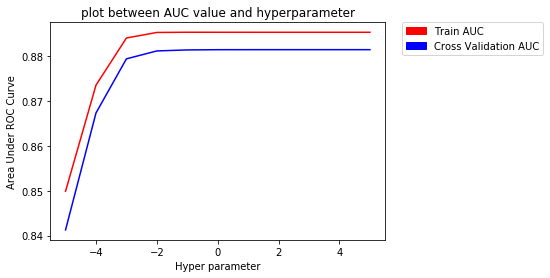

In [88]:
#Plot between AUC and hyperparameter for Validation data and training data
x_axis_log = []
for each in x_axis:
    x_axis_log.append(round(log(each, 10)))
plt.plot(x_axis_log, y_axis_train, color='red')
plt.plot(x_axis_log, y_axis_cv, color='blue')
plt.title('plot between AUC value and hyperparameter')
blue_patch = mpatches.Patch(color='blue', label='Cross Validation AUC')
red_patch = mpatches.Patch(color='red', label='Train AUC')
plt.legend(handles=[red_patch, blue_patch], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Hyper parameter')
plt.ylabel('Area Under ROC Curve')
plt.show()

In [ ]:
Observation:
    AUC is highest at 10**-2 for both train data and cross validation after which the curv saturates.Hence choosing
C=0.01 as optimal hyperparameter

In [89]:
#Training the Logistic Regression Model with the best hyperparameter
model = LogisticRegression(penalty='l2', C=0.01, class_weight = 'balanced', max_iter=1000)
model.fit(X_train_vec, Y_train)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

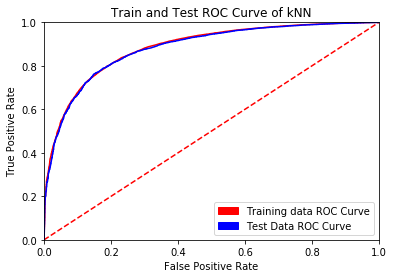

In [90]:
#Plotting the ROC Curve on both train and test data
y_scores = model.predict_proba(X_train_vec)
y_pred_train = model.predict(X_train_vec)
train_fpr, train_tpr, threshold = roc_curve(Y_train, y_scores[:, 1])
train_roc_auc = auc(train_fpr, train_tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(train_fpr, train_tpr, color='red')
blue_patch = mpatches.Patch(color='blue', label='Test Data ROC Curve')
red_patch = mpatches.Patch(color='red', label='Training data ROC Curve')
plt.legend(handles=[red_patch, blue_patch], loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Train and Test ROC Curve of kNN')

y_scores = model.predict_proba(X_test_vec)
y_pred_test = model.predict(X_test_vec)
fpr, tpr, threshold = roc_curve(Y_test, y_scores[:, 1])
test_roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue')
plt.show()

The AUC of the test data is 0.882306412061837
The AUC of the train data is 0.88533875781863
The confusion matrix, Recall and precision matrix for train data:
The confusion matrix, Recall and precision matrix for test data:


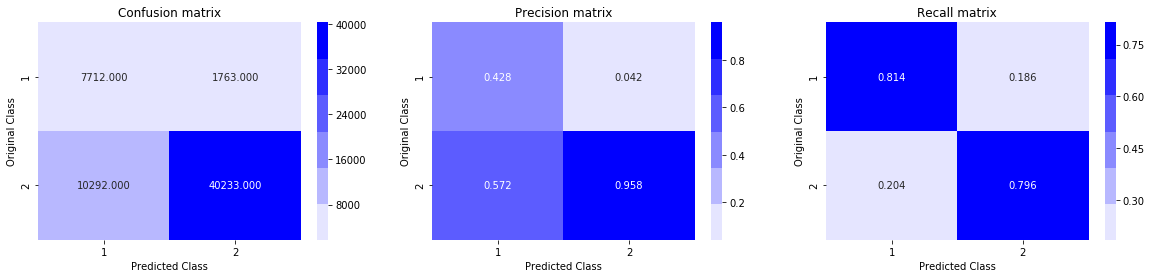

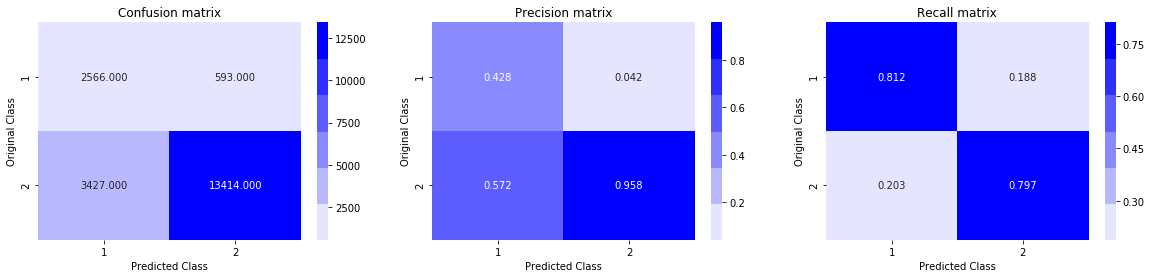

In [91]:
#Test Data AUC Value and Confusion matrix for test data and train data
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
print("The AUC of the test data is", test_roc_auc)
print("The AUC of the train data is", train_roc_auc)
print("The confusion matrix, Recall and precision matrix for train data:")
print("The confusion matrix, Recall and precision matrix for test data:")
plot_confusion_matrix(Y_train, y_pred_train)
plot_confusion_matrix(Y_test, y_pred_test)

# [6] Conclusions

In [0]:
# Please compare all your models using Prettytable library

In [92]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Type", "Regularizer", "Hyper Parameter", "Test AUC", "Recall - class 1 & 2", "Precision - class 1 & 2"]
x.add_row(["BOW model", "L1", 0.01 , 0.9369499968600048 ,[0.830 , 0.890] ,[0.598 , 0.966] ] )
x.add_row(["BOW model", "L2", 0.0001 , 0.9334967916505038 , [0.826 , 0.904], [0.618, 0.965] ] )
x.add_row(["TF-IDF model","L1", 0.01 ,0.9438699033372087 ,[ 0.846 , 0.890] ,[0.590, 0.969] ] )
x.add_row(["TF-IDF model", "L2", 0.0001 , 0.9374359489389608 , [0.828, 0.892], [ 0.589, 0.965] ] )
x.add_row(["Avg W2V model","L1", 1 , 0.5121206538580805 ,[ 0.289 , 0.725] ,[  0.165 , 0.845] ] )
x.add_row(["Avg W2V model", "L2", 0.01 , 0.5120218018106109 , [0.291 , 0.725], [0.166, 0.845] ] )
x.add_row(["TF-IDF W2v model","L1", 0.01 , 0.8819006092756003 ,[ 0.816  , 0.796] ,[0.429, 0.958] ] )
x.add_row(["TF-IDF W2v model", "L2", 0.01 , 0.882306412061837 , [ 0.812 , 0.797], [ 0.428, 0.958] ] )
print(x)

+------------------+-------------+-----------------+--------------------+----------------------+-------------------------+
|       Type       | Regularizer | Hyper Parameter |      Test AUC      | Recall - class 1 & 2 | Precision - class 1 & 2 |
+------------------+-------------+-----------------+--------------------+----------------------+-------------------------+
|    BOW model     |      L1     |       0.01      | 0.9369499968600048 |     [0.83, 0.89]     |      [0.598, 0.966]     |
|    BOW model     |      L2     |      0.0001     | 0.9334967916505038 |    [0.826, 0.904]    |      [0.618, 0.965]     |
|   TF-IDF model   |      L1     |       0.01      | 0.9438699033372087 |    [0.846, 0.89]     |      [0.59, 0.969]      |
|   TF-IDF model   |      L2     |      0.0001     | 0.9374359489389608 |    [0.828, 0.892]    |      [0.589, 0.965]     |
|  Avg W2V model   |      L1     |        1        | 0.5121206538580805 |    [0.289, 0.725]    |      [0.165, 0.845]     |
|  Avg W2V model

<h6>Final Observation:</h6>
 
<p>
1) When training a logistic regression model on BOW and TF-IDF data as expected it worked really well, because of the 
logistic regression's inherent nature of performing very well in high dimension space.Since BOW and TF-IDF based 
vectorizer gives a high dimensional vector, logistic regression trained in this data is giving a very high ROC value
of 93% in BOW and 94% in TF-IDF vector
</p>
<p>
2) But when we consider recall values of BOW data based LR model and TF_IDF data based LR model, there is some 
significant difference in the recall value of class 1 and class 2.This may be due to the very slight bias problem 
in the model which is causing a very slight underfit in the model
</p>
<p>
3) When calculating the sparsity of the weight vector obtained from the L1 regularized logistic regression model as 
expected a very sparse vector is obtained.In the 6727 lengthed BOW vector only 2269 features have a non-zero values.Nearly 66% of the features have a zero weight making 
the vector very very sparse.
</p>
<p>
4) Pertubation test is performed on the L2 regualarized logistic regression based on BOW data, we observe few features
have a sharp increase in the weight value and few other features have a sharp decrease in the weight after 
adding a small error in the training data as observed from the plot obtained after the pertubation test.Those features
are multicollinear.But more than 90% of the features shows a 0% variation as shown in the plot, hence we can deduce that
most of the features are multicollinear
</p>
<p>
5) When training the logistic regression model with the Avg w2v data, we can realize a drastic fall in the ROC of the 
model.This may be due to the drastic fall in the dimension of the training data as we obtain only a 50 length vector
from the Avg w2v vectorizer.Since logistic regression works well only in high dimensional spaces, this poor performance 
of the model is understandable.There is a very large difference in the recall and precision value of class 1 and 2 
showing a clear underfit signifying a high bias problem
</p>
<p>
6) TF_IDF weighted w2v data based LR model works much better than AVG w2v data based LR model but not better than BOW
and TF-IDF data based LR model.The recall value of class 1 and 2 are somewhat close but precision value of class 1
is much smaller than precision value of class 2.
</p>
<p>
7)On doing feature importance for the positive and negative class, for positive class the top 10 features we obtain are
great, love, best, delici, good, perfect, favorit, nice, excel and for negative class top 10 features are disappoint,
worst, terribl, return, aw, wast, horribl, bad, stale, didnt which is interpretable 
</p>

<h6>Final Conclusion</h6>
Logistic regression performs better than naive bayes for this problem